[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robmoore/zoomcamp-ts-project/blob/master/notebook-model.ipynb)

Click on the badge above to run this notebook in Colab.

We use the S&P 500 index data provided by Yahoo Finance below.

In [1]:
%%bash
# Install dependencies if we are in Colab
[[ -e /content ]] && pip install yahooquery

  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
%matplotlib inline

from yahooquery import Ticker

import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## EDA

We intend to perform an univariate analysis of the data, so we will focus on only one value.

In [3]:
ticker = Ticker("^GSPC")

# As with the paper by Saugat Aryal et al., we use a 20-year period.
df = ticker.history(start="1999-01-01", end="2020-01-01")

df

low      volume  ...        close     adjclose
symbol date                                 ...                          
^GSPC  1999-01-04  1219.099976   877000000  ...  1228.099976  1228.099976
       1999-01-05  1228.099976   775000000  ...  1244.780029  1244.780029
       1999-01-06  1244.780029   986900000  ...  1272.339966  1272.339966
       1999-01-07  1257.680054   863000000  ...  1269.729980  1269.729980
       1999-01-08  1261.819946   937800000  ...  1275.089966  1275.089966
...                        ...         ...  ...          ...          ...
       2019-12-24  3220.510010  1296540000  ...  3223.379883  3223.379883
       2019-12-26  3227.199951  2160680000  ...  3239.909912  3239.909912
       2019-12-27  3234.370117  2428670000  ...  3240.020020  3240.020020
       2019-12-30  3216.570068  3013290000  ...  3221.290039  3221.290039
       2019-12-31  3212.030029  2893810000  ...  3230.780029  3230.780029

[5283 rows x 6 columns]

In [4]:
# yahooquery returns the data indexed by ticker (`^GSPC`) and date.
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5283 entries, ('^GSPC', datetime.date(1999, 1, 4)) to ('^GSPC', datetime.date(2019, 12, 31))
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   low       5283 non-null   float64
 1   volume    5283 non-null   int64  
 2   high      5283 non-null   float64
 3   open      5283 non-null   float64
 4   close     5283 non-null   float64
 5   adjclose  5283 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 304.6+ KB


In [5]:
df.describe()

,low,volume,high,open,close,adjclose
count,5283.000000,5.283000e+03,5283.000000,5283.000000,5283.000000,5283.000000
mean,1553.323175,2.982766e+09,1571.913684,1562.972945,1563.194925,1563.194925
std,573.443163,1.518712e+09,574.951299,574.270273,574.357883,574.357883
min,666.789978,3.121200e+08,695.270020,679.280029,676.530029,676.530029
25%,1154.779968,1.519050e+09,1172.744995,1163.534973,1163.349976,1163.349976
50%,1340.479980,3.140730e+09,1361.390015,1351.930054,1351.949951,1351.949951
75%,1939.009949,3.878100e+09,1962.154968,1949.854980,1950.974976,1950.974976
max,3234.370117,1.145623e+10,3247.929932,3247.229980,3240.020020,3240.020020


In [6]:
# Remove ticker from index and tranform date to Pandas datetime
df = df.loc[df.index.get_level_values(0)[0]]
df.index = pd.to_datetime(df.index)

df

,low,volume,high,open,close,adjclose
date,,,,,,
1999-01-04,1219.099976,877000000,1248.810059,1229.229980,1228.099976,1228.099976
1999-01-05,1228.099976,775000000,1246.109985,1228.099976,1244.780029,1244.780029
1999-01-06,1244.780029,986900000,1272.500000,1244.780029,1272.339966,1272.339966
1999-01-07,1257.680054,863000000,1272.339966,1272.339966,1269.729980,1269.729980
1999-01-08,1261.819946,937800000,1278.239990,1269.729980,1275.089966,1275.089966
...,...,...,...,...,...,...
2019-12-24,3220.510010,1296540000,3226.429932,3225.449951,3223.379883,3223.379883
2019-12-26,3227.199951,2160680000,3240.080078,3227.199951,3239.909912,3239.909912
2019-12-27,3234.370117,2428670000,3247.929932,3247.229980,3240.020020,3240.020020


In [7]:
# Check for NAs
df.isnull().values.any()

False

In [8]:
# We are only interested in adjusted close, so limit the data accordingly
adjclose = df["adjclose"]

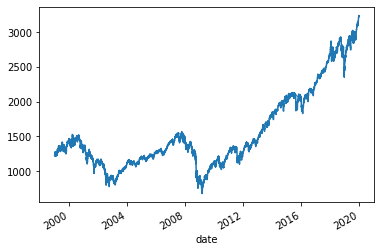

In [9]:
# Plot adjusted close
adjclose.plot();

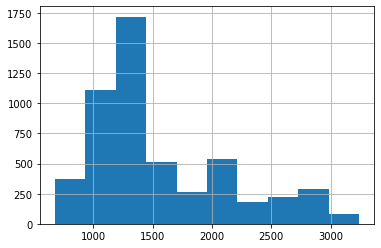

In [10]:
# The price data is skewed based on the values. As the chart above indicates,
# the majority of the pricing data is centered around $1400 until 2013 or 2014.
adjclose.hist();

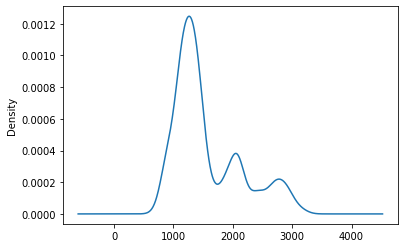

In [11]:
# The density of the data is somewhat less skewed, but still left of center.
adjclose.plot.kde();

In [12]:
# Test for statitionarity. We can see from the historical chart above that the
# data is trending, but let's test it.
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(adjclose)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: 1.4900870366371743
p-value: 0.997487317047142


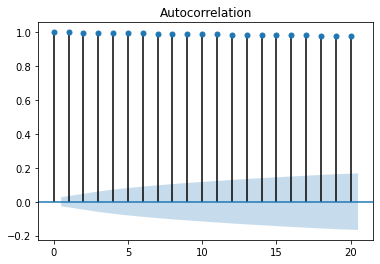

In [13]:
# The plot suggests that the data is not stationary as well.
plot_acf(adjclose, lags=20);

In [14]:
# Apply difference to data to make stationary. Only one differencing is necessary
# to reach stationarity.
diff_adjclose = np.diff(adjclose, n=1)

ADF_result = adfuller(diff_adjclose)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: -17.415712262061767
p-value: 4.857530374665212e-30


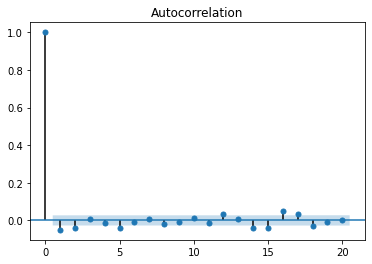

In [15]:
# The lack of any spikes in the data past the first point indicates
# a lack of autocorrelation and is suggestive of a random walk.
plot_acf(diff_adjclose, lags=20);

## Baseline analysis

Before turning to analyzing the data using machine learning, let's try some basic approaches to prediction and see how they perform. While not the focus of
this project, it proves informative in terms of what's possible using naive methods of prediction on random walk data.

The following is based on the approach presented in [Time Series Forecasting in Python](https://www.manning.com/books/time-series-forecasting-in-python-book).

In [16]:
# Split data into training and test for work below
train_df, test_df = train_test_split(df[["adjclose"]], test_size=0.2, shuffle=False)
train_df, test_df

(               adjclose
 date                   
 1999-01-04  1228.099976
 1999-01-05  1244.780029
 1999-01-06  1272.339966
 1999-01-07  1269.729980
 1999-01-08  1275.089966
 ...                 ...
 2015-10-13  2003.689941
 2015-10-14  1994.239990
 2015-10-15  2023.859985
 2015-10-16  2033.109985
 2015-10-19  2033.660034
 
 [4226 rows x 1 columns],                adjclose
 date                   
 2015-10-20  2030.770020
 2015-10-21  2018.939941
 2015-10-22  2052.510010
 2015-10-23  2075.149902
 2015-10-26  2071.179932
 ...                 ...
 2019-12-24  3223.379883
 2019-12-26  3239.909912
 2019-12-27  3240.020020
 2019-12-30  3221.290039
 2019-12-31  3230.780029
 
 [1057 rows x 1 columns])

In [17]:
# Isolate adjusted close data
train_s = train_df["adjclose"]
train_s

date
1999-01-04    1228.099976
1999-01-05    1244.780029
1999-01-06    1272.339966
1999-01-07    1269.729980
1999-01-08    1275.089966
                 ...     
2015-10-13    2003.689941
2015-10-14    1994.239990
2015-10-15    2023.859985
2015-10-16    2033.109985
2015-10-19    2033.660034
Name: adjclose, Length: 4226, dtype: float64

In [18]:
# Create 'y' values for testing predictions
pred_df = test_df.copy()
pred_df

,adjclose
date,
2015-10-20,2030.770020
2015-10-21,2018.939941
2015-10-22,2052.510010
2015-10-23,2075.149902
2015-10-26,2071.179932
...,...
2019-12-24,3223.379883
2019-12-26,3239.909912
2019-12-27,3240.020020


In [19]:
# Add a mean value to the data for use below
pred_df["mean"] = train_s.mean()
pred_df

,adjclose,mean
date,,
2015-10-20,2030.770020,1322.041479
2015-10-21,2018.939941,1322.041479
2015-10-22,2052.510010,1322.041479
2015-10-23,2075.149902,1322.041479
2015-10-26,2071.179932,1322.041479
...,...,...
2019-12-24,3223.379883,1322.041479
2019-12-26,3239.909912,1322.041479
2019-12-27,3240.020020,1322.041479


In [20]:
# Use the last value from the training dataset as the predicted value.
pred_df["last_value"] = train_s.iloc[-1]
pred_df

,adjclose,mean,last_value
date,,,
2015-10-20,2030.770020,1322.041479,2033.660034
2015-10-21,2018.939941,1322.041479,2033.660034
2015-10-22,2052.510010,1322.041479,2033.660034
2015-10-23,2075.149902,1322.041479,2033.660034
2015-10-26,2071.179932,1322.041479,2033.660034
...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034
2019-12-26,3239.909912,1322.041479,2033.660034
2019-12-27,3240.020020,1322.041479,2033.660034


In [21]:
# Determine the slope of the values to predict future prices using
# linear regression.
delta_X = len(train_s)
delta_y = train_s.iloc[-1] - train_s.iloc[0]

drift = delta_y / delta_X
drift

0.19061998546941553

In [22]:
# Produce a range of values for the test data using the slope
# and the origin starting at the first price in the training
# data.
pred_df["drift"] = (
    drift * np.arange(len(train_s) + 1, len(train_s) + 1 + len(test_df))
    + train_s.iloc[0]
)
pred_df

,adjclose,mean,last_value,drift
date,,,,
2015-10-20,2030.770020,1322.041479,2033.660034,2033.850654
2015-10-21,2018.939941,1322.041479,2033.660034,2034.041274
2015-10-22,2052.510010,1322.041479,2033.660034,2034.231894
2015-10-23,2075.149902,1322.041479,2033.660034,2034.422514
2015-10-26,2071.179932,1322.041479,2033.660034,2034.613134
...,...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034,2234.382879
2019-12-26,3239.909912,1322.041479,2033.660034,2234.573499
2019-12-27,3240.020020,1322.041479,2033.660034,2234.764119


A comparison of the three approaches to predicting the test data:

- mean: This approach does the poorest as mean proves not to be a robust statistic. This no surprise given the density of the data as seen above.
- last value: This approach is an improvement on mean, but still performs poorly as it captures a static point in time while the S&P 500 index is trending.
- drift: This approach does the best of the three, but still cannot keep pace with the change in slope over the following period.

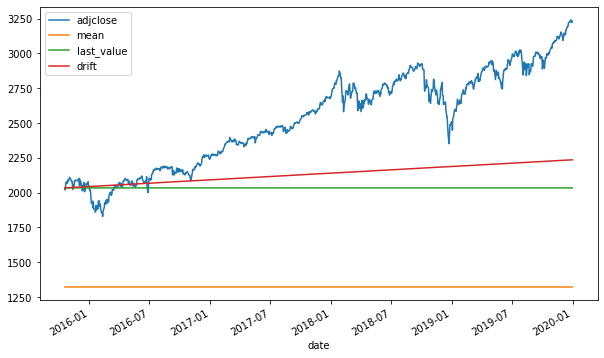

In [23]:
pred_df.plot(figsize=(10, 6));

A final approach explored here is to use the previous day's value as the predicted value. In a sense, it's like predicting that the temperature tomorrow will be the same as it is today. The results of this approach are impressive when plotted.

In [24]:
pred_df["prev_value"] = pred_df["adjclose"].shift()
pred_df["prev_value"].iloc[[0]] = train_s.iloc[-1]
pred_df

,adjclose,mean,last_value,drift,prev_value
date,,,,,
2015-10-20,2030.770020,1322.041479,2033.660034,2033.850654,2033.660034
2015-10-21,2018.939941,1322.041479,2033.660034,2034.041274,2030.770020
2015-10-22,2052.510010,1322.041479,2033.660034,2034.231894,2018.939941
2015-10-23,2075.149902,1322.041479,2033.660034,2034.422514,2052.510010
2015-10-26,2071.179932,1322.041479,2033.660034,2034.613134,2075.149902
...,...,...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034,2234.382879,3224.010010
2019-12-26,3239.909912,1322.041479,2033.660034,2234.573499,3223.379883
2019-12-27,3240.020020,1322.041479,2033.660034,2234.764119,3239.909912


Looked at from this perspective, the results look fantastic. It appears as if the model is able to predict future prices with uncanny accuracy.

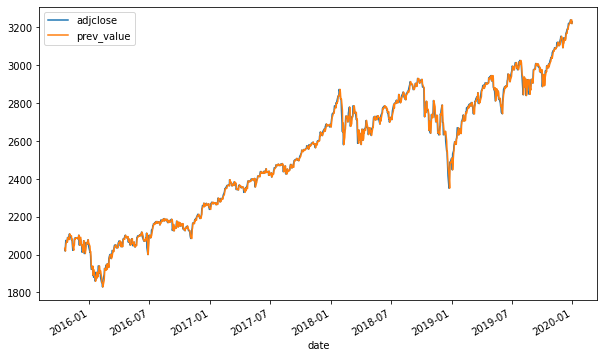

In [25]:
pred_df[["adjclose", "prev_value"]].plot(figsize=(10, 6));

However, note the lagging nature of the data when viewed up close. The prediction always is one step behind the previous day's value.

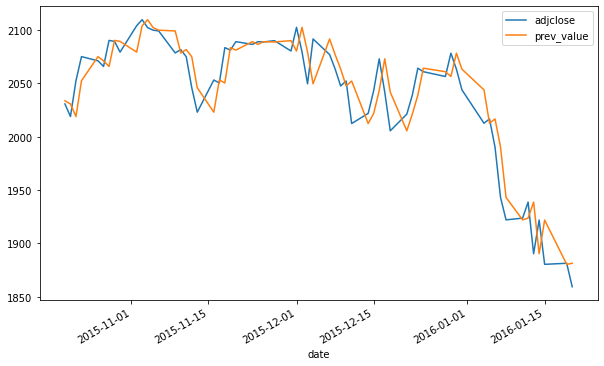

In [26]:
pred_df[["adjclose", "prev_value"]][:63].plot(figsize=(10, 6));

### Baseline Summary

We calculate the RMSE for each approach and plot it below. Notice the impressive numbers for the "previous value" approach. 

We will see a similar pattern emerge when using the "last value" approach as a baseline model. 

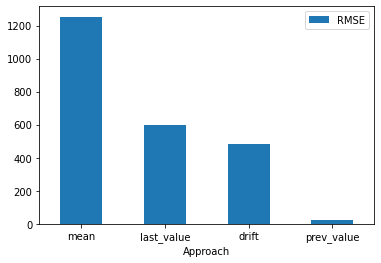

In [27]:
rmse_results = {
    "mean": mean_squared_error(pred_df["adjclose"], pred_df["mean"], squared=False),
    "last_value": mean_squared_error(
        pred_df["adjclose"], pred_df["last_value"], squared=False
    ),
    "drift": mean_squared_error(pred_df["adjclose"], pred_df["drift"], squared=False),
    "prev_value": mean_squared_error(
        pred_df["adjclose"], pred_df["prev_value"], squared=False
    ),
}

pd.DataFrame({"Approach": rmse_results.keys(), "RMSE": rmse_results.values()}).plot.bar(
    x="Approach", y="RMSE", rot=0
);

In [28]:
for name, value in rmse_results.items():
    print(f"{name:8s}\t{value:0.4f}")

mean    	1252.6407
last_value	600.0554
drift   	485.7396
prev_value	20.6400
